In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation, colors, rc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from IPython.display import set_matplotlib_formats, HTML, Image

set_matplotlib_formats('png', 'pdf')
rc('animation', html='html5')

In [3]:
import numpy as np
import scipy.special as spec
import scipy.integrate as inte
import sympy as sp
from sympy import vector
sp.init_printing()

In [4]:
# Variables mathématiques

Cart = vector.CoordSysCartesian('N')

x, y = sp.symbols('x y', real=True)
r = sp.symbols('r', positive=True)
omega = sp.symbols('omega', positive = True) # Pulsation
t = sp.symbols('t', positive=True) # Temps
Ic = sp.symbols('I', complex=True) # Courant électrique

mu = sp.symbols("mu", positive = True) # Perméabilité magnétique du milieu
c = sp.symbols("c", positive=True)      # Célérité de la lumière dans le milieu
k = omega/c                             # relation de dispersion

# Position du problème

Étant donné un fil électrique très long parcouru par un courant électrique $i$, on cherche à déterminer le champ magnétique créé par phénomène d'induction dans l'espace autour. On peut le détecter en approchant une boussole, de la limaille de fer ou d'autres aimants permanents du fil, voire approcher un autre fil électrique lui aussi parcouru par un courant.

# Implémentations en Python du champ magnétique et du courant électrique

Dans tout ce document, le courant et le champ magnétique seront représentés par des instances des classes `current` et `Field`, qui sont définies dans cette section. 

Chaque courant, par exemple, sera un objet de type `current`, dont les attributs, tels que `frequences`, `intensites`, `expr`, `func` contiendront les caractéristiques du courant, son expression mathématique, et une fonction numérique permettant de le calculer.

## Domaine spatial : classe `Domain`

In [5]:
class Domain:
    
    def __init__(self, xm, ym, I, J, x0=None, y0=None, eps=0):
        if x0 is None:
            x0 = -xm
        if y0 is None:
            y0 = -ym
        
        self.xm = xm
        self.xs = np.linspace(x0,xm,I)
        self.I = I
        
        self.ym = ym
        self.ys = np.linspace(y0,ym,J)
        self.J = J
        
        rad = np.sqrt(self.xs**2 + self.ys**2)
        cond = rad > eps
        
        self.rad = rad[cond]
        self.grid = np.meshgrid(self.xs[cond],
                self.ys[cond])
    
    def __call__(self):
        return self.grid

## Champ magnétique : classe `Field`

La cellule suivante définit les champs magnétiques comme une classe Python `Field`, dont les attributs sont notamment l'expression formelle du champ (`expr`), et la fonction numérique qui permet de calculer le champ en un point (`func`).

(**Attention code long**)

In [6]:
class Field:
    # Composante du potentiel vecteur associée à la pulsation omega
    A_component = -mu*Ic/4* \
        (sp.bessely(0,k*r) + sp.I*sp.besselj(0,k*r))*sp.exp(sp.I*omega*t)

    # Composante du champ magnétique associée à la pulsation omega
    B_component = - sp.diff(A_component, r).simplify()
    
    def __init__(self, intens=None, puls=None, phas=None):
        
        self.cel = 3e8 # Célérité des ondes ; à modifier en fonction du milieu
        
        if not(intens is None):
            if not(phas is None):
                intens = np.asarray(intens)*np.exp(1j*np.asarray(phas))
            self.pulsations = puls
            self.frequences = puls/(2*np.pi)
            self.spectre(intens, puls)
    
    def spectre(self, intens, puls):
        '''
        Construit le champ magnétique
        '''
        c0 = self.cel
        mu0_v = 4e-7*np.pi
        
        spectral_data = zip(intens, puls)
        self.impl_modules = ['numpy',{"besselj":spec.jn, "bessely":spec.yn}]
        
        orth_C = sum([
                self.B_component.subs({Ic: cur, omega:om, c:c0, mu:mu0_v}) \
                for (cur,om) in spectral_data if (cur!=0 and om!=0) ])
        
        orth_expr = sp.re(orth_C)
        
        orth_func = sp.lambdify((r, t), orth_expr, 
            modules = self.impl_modules)
        
        self.orth_C = orth_C
        self.orth_expr = orth_expr
        self.orth_func_r = orth_func
        
        # Fonctions en cartésien
        rxy = sp.sqrt(x**2+y**2)
        
        self.orth_func_xy = sp.lambdify((x, y, t), orth_expr.subs({r:rxy}), 
            modules = self.impl_modules)
        self.field_expr = (-y*Cart.i + x*Cart.j)*orth_expr.subs({r:rxy})/rxy
        self.field_func = sp.lambdify((x, y, t), 
            self.field_expr.to_matrix(Cart), 
            modules = self.impl_modules)
        
        
    def legende(self,ti):
        """Définit la légende"""
        return r'$t= {:.3e}$'.format(ti) + r"$\ \mathrm{s}$"
    
    def labelplot(self, fig, ax, custTitl=None):
        """
        Nomme les axes et le graphe pour le profil du champ.
        """
        ax.grid(True)
        ax.set_xlabel("Distance $r$ (m)")
        ax.set_ylabel("Valeur du champ (T)")
        if custTitl:
            ax.set_title(custTitl)
        else:
            ax.set_title(r'Champ magnétique ' + r'$\mathbf{B}$' \
                         + ' créé par un courant variable')
        
        fig.tight_layout()
    
    def _setup_plot(self, Omega):
        radii = Omega.rad
        
        fig = plt.figure(1, figsize=(8,5))
        ax = plt.axes()
        ax.set_xlim((np.amin(radii), np.amax(radii)))
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        return fig, ax
    
    def profile(self, Omega, times, custTitl = None):
        '''
        Construit les graphes du champ magnétique B aux temps donnés 
        dans la liste "times"
        '''
        func = self.orth_func_r
        radii = Omega.rad
        fig,ax = self._setup_plot(Omega) 

        if hasattr(times, '__iter__'):
            for ti in times:
                champ = func(radii, ti)
                ax.plot(radii, champ, label=self.legende(ti))
        else:
            champ = func(radii, times)
            ax.plot(radii, champ, label=self.legende(times))
        ax.legend(loc='best')
        
        self.labelplot(fig, ax, custTitl)
        self.graphe = fig
        
    def animate(self, Omega, t0, t1, animtime=10, custTitl = None):
        """
        Construit une animation du profil du champ entres les temps spécifiés.
        """
        
        func = self.orth_func_r
        radii = Omega.rad
        grid = Omega()
        
        fig, ax = self._setup_plot(Omega)
    
        line, = ax.plot([], [], lw=2)
        time_text = ax.text(0.02, 0.95, '',
                            transform=ax.transAxes)
        
        # Paramètres d'animation
        fps = 30
        frames = int(np.ceil(fps*animtime))
        dt = (t1 - t0)/frames # Saut en temps réel entre deux images
        interval = 1000/fps # Nombre de millisecondes entre deux images
        
        # Cadrage
        ymax = func(radii,t0).max()
        ax.set_ylim((-1.3*ymax,1.3*ymax))
        
        def init():
            line.set_data([],[])
            time_text.set_text(r'$t={:.2e}$'.format(t0))
            return line,
        
        def animate(i):
            ti = dt*i+t0
            champ = func(radii, ti)
            line.set_data(radii, champ)
            time_text.set_text(self.legende(ti))
            return line,
    
        self.labelplot(fig,ax,custTitl)
        anim = animation.FuncAnimation(fig, animate, init_func=init, 
                               frames=frames, interval=interval, blit=True)
        self.anim = anim
    
    def _setup_surface(self, Omega):
        grid, radii = Omega(), Omega.rad
        
        fig = plt.figure(2, figsize=(8,6))
        fig.suptitle(r"Champ magnétique $\mathbf{B}$")
        ax = fig.add_subplot(111, projection='3d')
        ax.grid(True)
        
        return grid,fig, ax
    
    def surface(self, Omega, t):
        """
        Portrait du champ magnétique à l'instant t
        """
        func = np.vectorize(self.orth_func_xy)
        radii = Omega.rad
        grid,fig,ax = self._setup_surface(Omega)
        
        normB = func(*Omega(), t)
        
        ax.plot_wireframe(*grid, normB)
        
        self.surf = fig
        
    def animate3D(self, Omega, t0, tm, fps=25):
        """
        tm -> intervalle [t0,tm]
        fps : nombre d'images par seconde à générer
        """
        animtime = 6 # durée de l'animation
        interval = 1000/fps # temps entre deux frames
        N = int(np.ceil(animtime*fps))
        dt = (tm-t0)/N # saut temporel entre chaque frame
        
        func = np.vectorize(self.orth_func_xy)
        grid,fig,ax = self._setup_surface(Omega)
        
        Bth = func(*grid, t0)
        zlims = (np.nanmin(Bth),1.5*np.nanmax(Bth))
        
        surf = ax.plot_wireframe(*grid, Bth)
        time_text = ax.text2D(0.5,1,r'$t={:.2e}$'.format(t0),
                    horizontalalignment='center',
                    transform=ax.transAxes)
        ax.set_zlim(zlims)
        
        def update(i):
            ax.clear()
            ax.set_zlim(zlims)
            ti = i*dt + t0
            Bth = func(*Omega(), ti)
            s = r'$t={:.3e}$'.format(ti)
            time_text = ax.text2D(0.5,1,s,
                    horizontalalignment='center',
                    transform=ax.transAxes)
            data = ax.plot_wireframe(*grid, Bth)
            return data, time_text
        
        anim = animation.FuncAnimation(fig,update,
                        frames=N,interval=interval)
        self.anim3D = anim
        self.animfig = fig
        self.animax = ax

On pourrait éventuellement implémenter une représentation du champ électrique... Le lecteur intrépride pourra s'y aventurer en introduisant une sous-classe de `Field` ou en la modifiant.

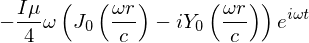

In [7]:
# Composante du champ électrique associée à la pulsation omega
A_component = Field().A_component
E_component = -sp.diff(A_component, t).expand().simplify()
E_component

## Courant électrique : classe `current`

La cellule suivante définit les courants électriques comme une classe Python `Current`, dont les attributs sont notamment l'expression formelle du champ (`expr`), et la fonction numérique qui permet de calculer le courant à un instant (`func`).

In [8]:
class Current:
    # Composante du courant électrique de pulsation omega
    cour_component = Ic*sp.exp(sp.I*omega*t)
    cour_component
    def _spectre(self, intens):
        """
        Calcule l'expression mathématique 'self.expr' et définit une fonction
        numérique 'self.func' permettant de calculer le courant à un instant.
        """
        spector = zip(intens,puls)
        cour = sum([self.cour_component.subs({Ic:i, omega:om}) \
                for i,om in spector ])
        cour_re = sp.re(cour)
        
        cour_func = sp.lambdify((t),cour_re,modules=['numpy'])
        
        self.expr = cour_re
        self.func = cour_func
    
    def _expr(self, expr):
        """
        Définit le courant selon son expression."""
        self.expr = expr
        self.func = sp.lambdify(t, expr, modules=['numpy'])
    
    def __init__(self, intens=None, puls=None, phas=None):
        """
        Étant donné le spectre (intensités et pulsations), initialise le courant
        en attribuant les fréquences/pulsations du courant, les intensités
        (complexes) associées. L'argument d'une intensité complexe correspond 
        au déphasage de la composante du courant associée.
        
        Si les phases sont précisées, elles sont ajoutées aux arguments des
        intensités."""
        if not(intens is None):
            if not(phas is None):
                intens = np.asarray(intens)*np.exp(1j*np.asarray(phas))

            self.intensities = intens
            self.pulsations = puls
            self.frequences = self.pulsations/(2*np.pi)

            self._spectre(intens)
    
    def fft(self, fs, N):
        dt = 1/fs
        sample_time = np.linspace(-N*dt,N*dt,N+1)
        samples = self.func(sample_time)
        
        self.intensities = np.fft.rfft(samples) # Intensités
        self.pulsations = np.fft.rfftfreq(N, d=1/fs)     # Pulsations associées
        self.frequences = self.pulsations/(2*np.pi)
    
    def draw(self, tmin, tmax, N=1000, custTitle=None):
        """
        Construit la représentation graphique de la fonction i(t),
        stockée dans l'attribut 'self.graphe'
        
        custTitle : titre optionnel à fournir
        """
        times = np.linspace(tmin, tmax, N)
        
        fig,ax=plt.subplots(1,1,figsize=(8,5))
        ax.grid(True)
        
        if custTitle:
            ax.set_title(custTitle)
        else:
            ax.set_title(r"Courant électrique")
        ax.plot(times, self.func(times))
        ax.set_xlabel(r"Temps $t$ $(\mathrm{s})$")
        ax.set_ylabel(r"Intensité du courant $i$ ($A$)")
        fig.tight_layout()
        self.graphe = fig
    
    def draw_fft(self):
        fig, (ax0,ax1) = plt.subplots(2,1, figsize=(8,8))
        
        xlbl = r'Pulsation $\omega$ ($\mathrm{Hz}$)'
        
        ax0.grid(True)
        ax0.set_xlabel(xlbl)
        ax0.set_ylabel(r"Amplitude $I(\omega)$ ($\mathrm{A}$)")
        ax0.plot(self.pulsations, np.abs(self.intensities))
        
        ax1.grid(True)
        ax1.set_xlabel(xlbl)
        ax1.set_ylabel(r"Phase $\phi(\omega)$ ($\mathrm{rad}$)")
        ax1.plot(self.pulsations, np.angle(self.intensities))
        
        ax0.set_title(r"Spectre en fréquence du courant $i(t)$")
        fig.tight_layout()
        
        self.graphe_fft = fig

# Exemples d'utilisation

## Données initiales

Entrez dans la variable `freqs` les fréquences du courant voulu, et dans `phas` les phases. Exécutez la cellule (`Ctrl + Entrée` sur le clavier) pour définir la fonction de champ :

In [9]:
freqs = np.array([n*1e8 for n in range(5,7)] + \
    [n*1e6 for n in [1,2,8]])

puls = 2*np.pi*np.asarray(freqs) # Pulsations associées
intens = np.array([2,3,1,6,6]) # Intensités des composantes

phases = np.array([0,0,0,0,0]) # Phases des composantes

B_field = Field(intens, puls, phases)

In [ ]:
courant = Current(intens, puls, phases)
courant.draw(0,1e-6)
courant.graphe.show()

La cellule suivante définit les distances minimale et maximale pour lesquels tracer le profil du champ magnétique :

In [11]:
Omega = Domain(1,1,200,200, True, 0.01)

times = [1e-8*8*k for k in range(5)]

B_field.profile(Omega,times)

<IPython.core.display.Javascript object>


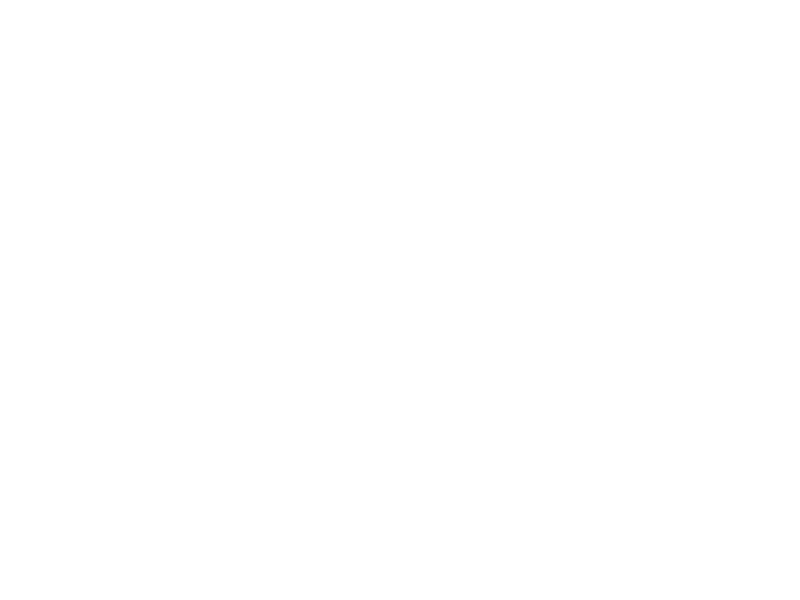

In [12]:
B_field.surface(Omega, 0)

## Animations

On peut animer le profil du champ magnétique entre deux instants $t_0$ et $t_m$ :

In [13]:
Omega = Domain(1,1,200,200, 0.03)
times_an = (0, 1e-6) # (t0, tm)

B_field.animate(Omega,*times_an)
B_field.anim

Et visualiser cela en trois dimensions:

In [14]:
Omega = Domain(2,2,48,48,eps=0.03)
B_field.animate3D(Omega, *times_an)

In [15]:
B_field.anim3D.save('onde.mp4')

# Exemple d'application: Paquet d'ondes

In [16]:
def gaussienne(tau):
    tard = t - 0
    expr = sp.exp(-tard**2/(2*tau**2))*sp.cos(10*t/tau)
    out = Current()
    out._expr(expr)
    return out

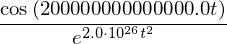

In [17]:
tau = 5e-14
N = 2**9 # Nombre d'échantillons
fs = 2**48 # Fréquence d'échantillonnage

courant = gaussienne(tau)
courant.expr

Courbe représentative du courant $i(t) = e^{-t^2/(2\tau^2)}\cos\left(\frac{t}{\tau}\right)$:

<IPython.core.display.Javascript object>


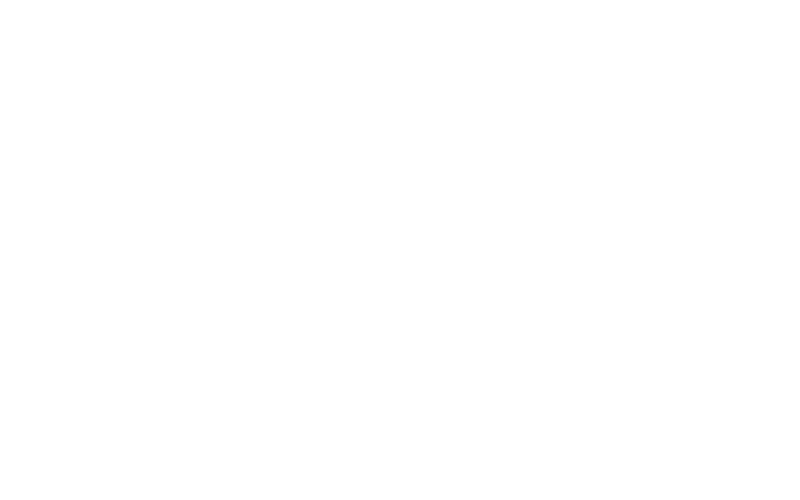

In [18]:
titros = r"Paquet gaussien d'extension $\tau = {:.2e}$ s".format(tau)
courant.draw(-N/fs,N/fs, N+1, custTitle = titros)

Construction du spectre du courant via la méthode `bake_fft`:

<IPython.core.display.Javascript object>


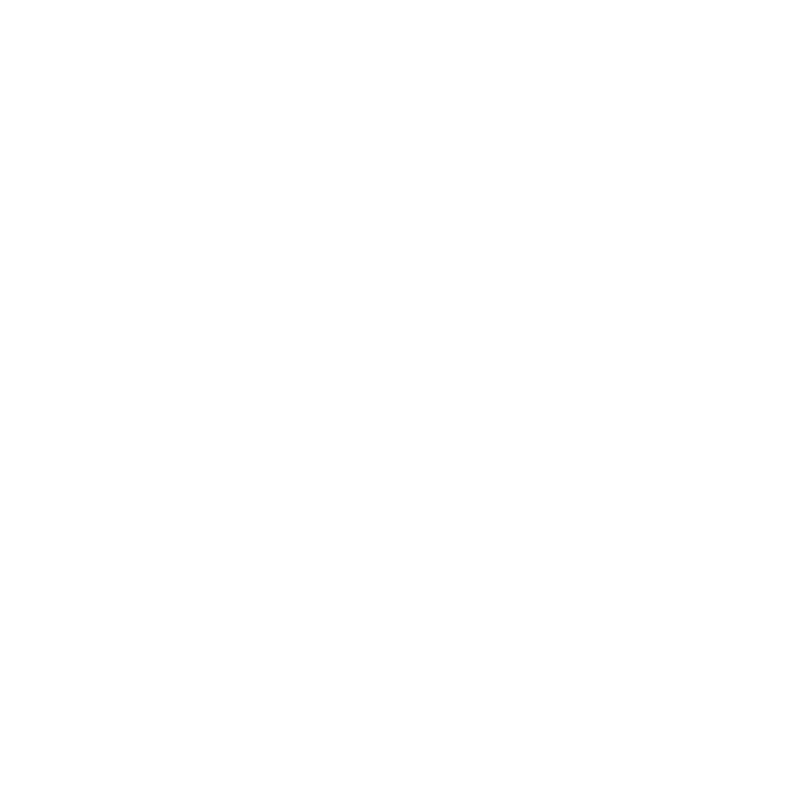

In [19]:
courant.fft(fs, N)
courant.draw_fft()

In [20]:
intens = courant.intensities
puls = courant.pulsations

In [21]:
B_field = Field(intens, puls)

In [22]:
rmin = 0.178
rmax = 0.18
xmin = rmin/2**0.5
xmax = rmax/2**0.5

Omega = Domain(xmax,xmax,512,512,x0=xmin,y0=xmin)

times = [1e-11*k for k in [1,2]]
titre_gauss = "Réponse à un paquet gaussien d'extension " + \
        r"$\tau={:.2e}$".format(tau) + " $\mathrm{s}$"
B_field.profile(Omega, times, custTitl=titre_gauss)

In [ ]:
times = (0,2e-11)
Omega = Domain(xmax,xmax,512,512,xmin,xmin,False)

B_field.animate(Omega,*times, 
    custTitl = "Propagation d'un paquet gaussien d'extension " + \
            r"$\tau = {:.2e}$".format(tau) + \
            "$\mathrm{s}$")

B_field.anim

In [ ]:
times = (0,2e-11)
Omega = Domain(xmax,xmax,64,64,xmin,xmin,False)
B_field.animate3D(Omega, *times)

B_field.anim3D.save('surface_paquet.mp4')

# Théorie

Le champ magnétique $\mathbf{B}$ dérive d'un champ $\mathbf A$ appelé *potentiel vecteur* : $\mathbf{B} = \boldsymbol\nabla\wedge\mathbf{A}$. Par symétrie cylindrique, on a $\mathbf{B}(\mathbf r, t) = B(r,t)\mathbf{e}_\theta$, puis $\mathbf A(\mathbf r,t) = A(r,t)\mathbf e_z$.

Le potentiel vecteur $\mathbf{A} = A(r,t)\mathbf{e}_z$ est solution de l'équation d'onde

\begin{equation}
\Delta\mathbf A  - \frac{1}{c^2}\frac{\partial^2\mathbf A}{\partial t^2} = - \mu_0\mathbf{J}(r,t),
\end{equation}

avec $\mathbf J(\mathbf r,t)  = i(t)\delta(r)\delta(\theta)\mathbf{e}_z$ la densité volumique de courant, de sorte que pour toute surface $(\Sigma)$ traversée par le fil, on ait que le flux de $\mathbf J$ soit égal au courant parcourant le fil : $\iint_{(\Sigma)}\mathbf J(\mathbf r,t)\cdot\,\mathrm d\boldsymbol \sigma = i(t)$.


Pour un courant sinusoïdal $i(t) = I\exp(i\omega t)$, le potentiel s'écrit $\mathbf A(\mathbf r,t) = f(r)\exp(i\omega t)\mathbf e_z$ et l'équation aux dérivées partielles se réduit à

\begin{equation}
\frac{1}{r}\frac{\mathrm d}{\mathrm dr}\left(r \frac{\mathrm df}{\mathrm dr}\right) + k^2f(r) = -\frac{\mu_0 I}{2\pi r}\delta(r)
\end{equation}

avec $k=\dfrac{\omega}{c}$.

La solution prend la forme

$$
f(r) = -\frac{\mu_0 I}{4}\left(Y_0(kr)+i J_0(kr)\right)
$$

où $J_0,Y_0$ sont les 0-ièmes fonctions de Bessel de la première et seconde espèce, solutions de $$xy''(x) + y'(x) + xy(x) = 0.$$